In [55]:
import math as m
import matplotlib.pyplot as plt
import numpy as np
from itertools import chain,islice,product
from numba import jit
from time import time
import numexpr as ne

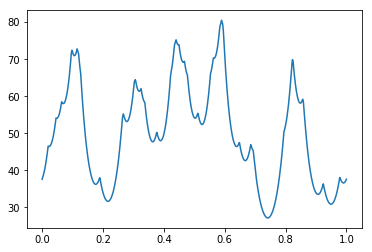

In [2]:
%matplotlib inline

sigma = 0.05

ulist = [np.random.uniform(size=40) for i in range(0,200)]

def fsubk(t0,ulistpos): 
    const = float(1/(m.exp((2**(1/2))/sigma)-1))
    s = ulist[ulistpos]
    a = sum(map(lambda u: float(m.exp((u-t0)/(sigma/(2**(1/2))))*const),s))
    b = sum(map(lambda u: float(m.exp((t0-u)/(sigma/(2**(1/2))))*const),s))
    c1 = [u for u in s if t0>=u]
    c2 = [u for u in s if t0<u]
    C1 = sum(map(lambda u: float(m.exp((u-t0)/(sigma/(2**(1/2))))),c1))
    C2 = sum(map(lambda u: float(m.exp((t0-u)/(sigma/(2**(1/2))))),c2))
    return float(((a+b+C1+C2)*(1/(sigma*(2**(1/2)))))+10)

vfunc = np.vectorize(fsubk,excluded=['ulistpos']) 
x = np.linspace(0,0.9999999999999,1000) 
y = vfunc(t0=x,ulistpos=0) 
plt.plot(x,y)
plt.show()


In [3]:
start = time()
fsubk(0.6,0)
end = time()
end-start

0.00021195411682128906

In [3]:
# prepare lambda(t)'s (or p1 and p2) for the Poisson Process
delta = 0.0001
p_x = np.asarray([(i+0.5)*delta for i in range(0,int(1/delta))]) # midpoint approximation
p1 = np.fromiter(chain.from_iterable((vfunc(t0=p_x,ulistpos=i) for i in range(0,100))),float)
p2 = np.fromiter(chain.from_iterable((vfunc(t0=p_x,ulistpos=i) for i in range(100,200))),float)

In [4]:
len(p1) # should be 100/delta

1000000

In [5]:
len(p2) # should be 100/delta

1000000

In [6]:
# the Poisson Point Process (times1 and times2 are the spike times for each neuron)
flipacoinrandoms = np.random.uniform(size=int(100/delta))
times1 = [round((v+1/2)*delta,4) for v in range(0,int(100/delta)) if flipacoinrandoms[v]<=float(p1[v]*delta)]
times2 = [round((v+1/2)*delta,4) for v in range(0,int(100/delta)) if flipacoinrandoms[v]<=float(p2[v]*delta)]

In [7]:
len(times1) # should be about 5000 even if I make delta finer

5056

In [8]:
len(times2) # should be about 5000 even if I make delta finer

4959

In [9]:
# The f_k average function for each neuron

def fsubkav1(t00):
    return np.mean([fsubk(t00,i) for i in range(0,100)])

def fsubkav2(t00):
    return np.mean([fsubk(t00,i) for i in range(100,200)])

In [10]:
# the psth function for each neuron

def psth1(t0):
    psthlist = [1 for i in range(0,len(times1)) if float(t0-0.025)<=times1[i]%1<float(t0+0.025)]
    return float(sum(psthlist)/(100*0.050))

def psth2(t0):
    psthlist = [1 for i in range(0,len(times2)) if float(t0-0.025)<=times2[i]%1<float(t0+0.025)]
    return float(sum(psthlist)/(100*0.050))

12.956662893295288


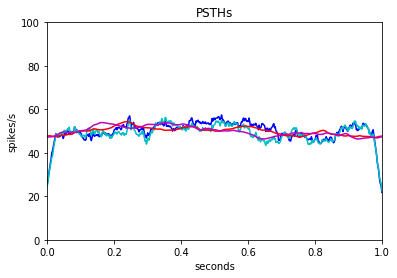

In [11]:
# plotting stuff (f_k averages and psths)
start = time()
t = np.linspace(0,1,500)
vfunc2 = np.vectorize(psth1)
y2 = vfunc2(t)
vfunc3 = np.vectorize(psth2)
y3 = vfunc3(t)
vfunc4 = np.vectorize(fsubkav1)
y4 = vfunc4(t)
vfunc5 = np.vectorize(fsubkav2)
y5 = vfunc5(t)
plt.axis([0,1,0,100])
plt.plot(t,y2,'b',t,y3,'c',t,y4,'r',t,y5,'m')
plt.title('PSTHs')
plt.xlabel('seconds')
plt.ylabel('spikes/s')
plt.yticks(np.arange(0,120,20))
plt.show
end = time()
print(end-start)

In [25]:
# generate a cartesian product of the two spike times (double summation in paper)
# product is short for itertools.product
# cartprod is an array of tuples (think coordinates)
#cartprod = np.asarray(list(product(times1,times2)))
cartprod = np.transpose([np.tile(times1, len(times2)), np.repeat(times2, len(times1))])
diff = np.diff(cartprod).ravel()

In [26]:
len(cartprod) # should be about 5000^2 = 25 million

25072704

In [27]:
# np.diff generates list of differences between x and y for every (x,y) in cartprod
# -1 times np.diff makes it so that it is times1 - times2 guaranteed
# the stuff inside np.sum generates a list of True/False values. 
# True is 1 and False is 0, so it sums all the ones (where the inequality is satisfied)
# and zeros (where it's not satisfied)
def cch(tau):
    x = abs(diff-tau)<0.001
    return np.sum(x)

In [38]:
start = time()
cch(0)
end = time()
end-start

0.22729110717773438

In [56]:
@jit(nopython=True)
def cch_jit(tau,cartprod):
    count = 0
    tau = -tau
    for i in range(cartprod.shape[0]):
        count += np.less(np.abs(tau - (cartprod[i, 1]- cartprod[i, 0])), 0.001)
    return count

In [58]:
cs = np.transpose([np.tile(times1, len(times2)), np.repeat(times2, len(times1))])
start = time()
cch_jit(0,cs)
end = time()
end-start

0.02277398109436035

In [90]:
def cch_numexpr(a, tau):
    d = {'a0':a[:,0],'a1':a[:,1]}
    return np.count_nonzero(ne.evaluate('abs(a0-a1-%s)<0.001'%tau,d))

In [94]:
start = time()
cch_numexpr(cartprod,tau=0)
end = time()
end-start

0.07430505752563477

287.95140194892883


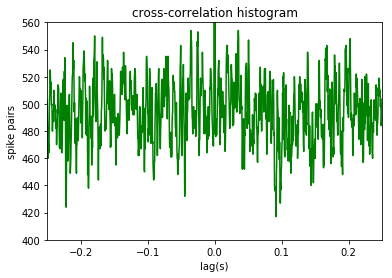

In [47]:
# more plotting stuff (unoptimized cch)
start = time()
t2 = np.linspace(-0.25,0.25,1250) 
y6 = np.fromiter(map(cch,t2),float)
plt.plot(t2,y6,'g')
plt.title('cross-correlation histogram')
plt.xlabel('lag(s)')
plt.ylabel('spike pairs')
plt.axis([-0.25,0.25,400,560])
end = time()
print(end-start)

30.07964277267456


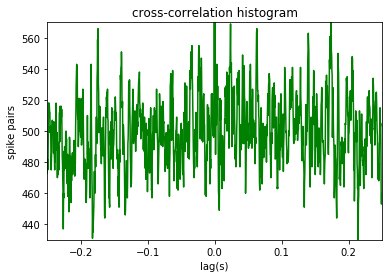

In [59]:
# more plotting stuff (cch_jit)
start = time()
t2 = np.linspace(-0.25,0.25,1250) 
y6 = np.fromiter(map(lambda r: cch_jit(r,cs),t2),float)
plt.plot(t2,y6,'g')
plt.title('cross-correlation histogram')
plt.xlabel('lag(s)')
plt.ylabel('spike pairs')
plt.axis([-0.25,0.25,430,570])
end = time()
print(end-start)

72.83974885940552


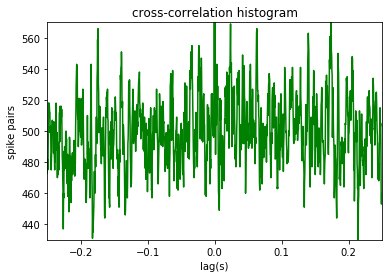

In [71]:
# more plotting stuff (cch_numexpr)
start = time()
t2 = np.linspace(-0.25,0.25,1250) 
y6 = np.fromiter(map(lambda r: cch_numexpr(cs,r),t2),float)
plt.plot(t2,y6,'g')
plt.title('cross-correlation histogram')
plt.xlabel('lag(s)')
plt.ylabel('spike pairs')
plt.axis([-0.25,0.25,430,570])
end = time()
print(end-start)